In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
# import sys
# import os

from datetime import timedelta

from utils.visual import generate_colors
from utils.visual import print_dict_pretty
from core.grid_trading import GridTrading
from core.binance_data_fetcher import BinanceDataFetcher

In [10]:
def fetch_crypto_data_history(symbols, period="1y", interval="1d"):
    crypto_data = {}
    successfully_fetched = []

    for symbol in symbols:
        try:
            ticker = yf.Ticker(f"{symbol}-USD")
            data = ticker.history(period=period, interval=interval)

            if len(data) > 100:  # Ensure enough data for grid trading
                # Ambil tanggal hari ini - 2 hari
                cutoff_date = (pd.Timestamp.today() - timedelta(days=2)).tz_localize('UTC')

                # Filter data sampai cutoff_date
                data = data[data.index <= cutoff_date]

                crypto_data[symbol] = data
                successfully_fetched.append(symbol)
                print(f"Successfully fetched data for: {successfully_fetched}\n")
            else:
                print(f"Insufficient data for {symbol}, skipping...\n")

        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}\n")

    return crypto_data

In [11]:
def crypto_data_overview(crypto_data):
    for symbol, data in crypto_data.items():
        print(f"--- {symbol} ---")
        print(f"Data Shape : {data.shape}")
        print(f"Date Range : {data.index.min().date()} to {data.index.max().date()}")

        # Check basic data quality
        missing_values = data.isnull().sum().sum()
        zero_volume = (data["Volume"] == 0).sum()

        if missing_values > 0:
            print(f"Missing Values Detected:\n{missing_values}")
        if zero_volume > 0:
            print(f"Zero Volume Days Detected: {zero_volume}")
        if missing_values == 0 and zero_volume == 0:
            print(f"Data Quality Check Passed: No missing values or zero volume days.")

def plot_price_overview(crypto_data):
    plt.figure(figsize=(14, 7))
    colors = generate_colors(len(crypto_data))

    latest_changes = []
    for i, (symbol, data) in enumerate(crypto_data.items()):
        normalized = (data["Close"] / data["Close"].iloc[0] - 1) * 100
        plt.plot(data.index, normalized, label=symbol, color=colors[i])
        change = normalized.iloc[-1]
        latest_changes.append(f"{symbol}: {change:.2f}%")

    # Sort latest_changes by percentage descending
    latest_changes.sort(key=lambda x: float(x.split(": ")[1][:-1]), reverse=True)

    plt.title("Cryptocurrency Price Overview")
    plt.xlabel("Date")
    plt.ylabel("Price Change (%)")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.axhline(0, color="black", linestyle="--", alpha=0.3)

    plt.text(
        0.02,
        0.95,
        "Latest Performance:\n" + "\n".join(latest_changes),
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
    )

    plt.tight_layout()
    plt.show()

def clean_data_trading(data, symbol):
    print(f"\n=== Cleaning Data for {symbol} ===")
    original_length = len(data)
    cleaned = data.copy()

    # # 1️⃣ Cek missing values sebelum dihapus
    missing_before = cleaned.isnull().sum()
    if missing_before.any():
        print("\n[Before Cleaning] Missing Values per Column:")
        print(missing_before[missing_before > 0])
    else:
        print("\nNo missing values found — data looks clean ✅")

    # # 2️⃣ Hapus baris yang punya missing di kolom OHLCV
    cleaned = cleaned.dropna(subset=["Open", "High", "Low", "Close", "Volume"])
    print(f"\nRows dropped (missing OHLCV): {original_length - len(cleaned)}")

    # # 3️⃣ Cek inkonsistensi High/Low
    inconsistent_high = (cleaned["High"] < cleaned[["Open", "Close"]].max(axis=1)).sum()
    inconsistent_low = (cleaned["Low"] > cleaned[["Open", "Close"]].min(axis=1)).sum()
    print(f"Inconsistent High values: {inconsistent_high}")
    print(f"Inconsistent Low values: {inconsistent_low}")

    # # 4️⃣ Pastikan High >= Max(Open, Close) dan Low <= min(Open, Close)
    cleaned['High'] = np.maximum(cleaned['High'], np.maximum(cleaned['Open'], cleaned['Close']))
    cleaned['Low'] = np.minimum(cleaned['Low'], np.minimum(cleaned['Open'], cleaned['Close']))

    # 5️⃣ Handle zero or missing volume safely
    if 'Volume' in cleaned.columns:
        zero_vol_mask = (cleaned['Volume'] <= 0) | (cleaned['Volume'].isna())
        n_zero = zero_vol_mask.sum()

        if n_zero > 0:
            print(f"⚠️ Detected {n_zero} zero-volume rows — applying forward fill (best practice fix).")

            # Forward fill untuk menjaga kontinuitas waktu
            cleaned.loc[zero_vol_mask, 'Volume'] = np.nan
            cleaned['Volume'] = cleaned['Volume'].ffill().bfill()

            # Tampilkan hasil perbaikan
            fixed_count = cleaned['Volume'].isna().sum()
            if fixed_count == 0:
                print(f"✅ Successfully fixed all {n_zero} zero-volume entries.\n")
            else:
                print(f"⚠️ {fixed_count} entries still have NaN volume (unfixable gaps).\n")
        else:
            print("✅ No zero-volume rows detected.\n")

    # 6️⃣ Adjust Extreme Outlier
    for col in ['Open', 'High', 'Low', 'Close']:
        # Calculate Q1, Q3, and IQR
        Q1 = cleaned[col].quantile(0.25)
        Q3 = cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds for extreme outliers (using 3 * IQR)
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        # Identify extreme outliers
        outliers = (cleaned[col] < lower_bound) | (cleaned[col] > upper_bound)
        if outliers.sum() > 0:
            print(f"Adjust {outliers.sum()} extreme outliers in {col}")
            # Instead of removing, cap the values at bounds
            cleaned[col] = cleaned[col].clip(lower=lower_bound, upper=upper_bound)
        else:
            print('No Outlier Found')
    
    # 7️⃣ Sort by date (ensure chronological order)
    cleaned = cleaned.sort_index()
    print(f"Data sorted chronologically from {cleaned.index[0].date()} to {cleaned.index[-1].date()}")
    print(f"\nFinal shape: {cleaned.shape} (removed {original_length - len(cleaned)} rows)\n")

    return cleaned

def quick_quality_check(crypto_data) :
    all_good = True

    for symbol, data in crypto_data.items():
        print(f"{symbol}:")
        issues = []

        # Check for missing values
        missing_values = data.isnull().sum()
        if missing_values.any():
            issues.append(f"Missing values detected:\n{missing_values[missing_values > 0]}")

        # Check for Zero price
        zero_prices = (data[['Open', 'High', 'Low', 'Close']] <= 0).sum()
        if zero_prices.any():
            issues.append(f"Zero or negative prices detected:\n{zero_prices[zero_prices > 0]}")

        # Check for data length
        min_required_rows = 100  # Minimum required days of data
        if len(data) < min_required_rows:
            issues.append(f"Insufficient data: {len(data)} rows (minimum {min_required_rows} required)")

        # Check date continuity
        all_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
        missing_dates = all_dates.difference(data.index)
        if len(missing_dates) > 0:
            issues.append(f"Missing dates detected: {missing_dates}")

        if issues:
            all_good = False
            print("Issues found:")
            for issue in issues:
                print(f"- {issue}")
            print()
        else:
            print("All checks passed!\n")

    return all_good

def volatility_analyze_for_grid(crypto_dict):
    volatility_data = {}

    for symbol, data in crypto_dict.items():
        # Calculate daily returns
        returns = data["Close"].pct_change().dropna()

        # Different volatility measures
        hourly_volatility = returns.std() * np.sqrt(1/24) * 100
        four_hour_volatility = returns.std() * np.sqrt(1/6) * 100
        daily_volatility = returns.std() * 100
        weekly_volatility = returns.std() * np.sqrt(7) * 100
        monthly_volatility = returns.std() * np.sqrt(30) * 100
        annual_volatility = returns.std() * np.sqrt(365) * 100

        # Price range analysis
        avg_daily_range = ((data["High"] - data["Low"]) / data["Close"] * 100).mean()

        tf_factor = {
            "hourly": 1 / np.sqrt(24),
            "four_hour": 1 / np.sqrt(6),
            "daily": 1,
            "weekly": np.sqrt(7),
            "monthly": np.sqrt(30),
            "annual": np.sqrt(365),
        }

        # --- Hitung average range by timeframe
        avg_range_by_tf = {tf: avg_daily_range * factor for tf, factor in tf_factor.items()}

        # Hitung Volatility Close-Close
        std_returns = returns.std()
        mean_returns = returns.mean()
        cleaned_returns = returns.where(
            abs(returns - mean_returns) <= 3 * std_returns
        ).dropna()
        win_rate = (cleaned_returns > 0).mean() * 100

        volatility_data[symbol] = {
            "win_rate": win_rate,
            "hourly_volatility": hourly_volatility,
            "four_hour_volatility": four_hour_volatility,
            "daily_volatility": daily_volatility,
            "weekly_volatility": weekly_volatility,
            "monthly_volatility": monthly_volatility,
            "annual_volatility": annual_volatility,
            "average_range": avg_range_by_tf
        }
    
    # 4️⃣ Hitung threshold dari persentil volatilitas (dynamic)
    hourly_vols = np.array([v["hourly_volatility"] for v in volatility_data.values()])
    four_hour_vols = np.array([v["four_hour_volatility"] for v in volatility_data.values()])
    daily_vols = np.array([v["daily_volatility"] for v in volatility_data.values()])
    weekly_vols = np.array([v["weekly_volatility"] for v in volatility_data.values()])
    monthly_vols = np.array([v["monthly_volatility"] for v in volatility_data.values()])
    annual_vols = np.array([v["annual_volatility"] for v in volatility_data.values()])

    thresholds = {
        "hourly": np.percentile(hourly_vols, [33, 66]),
        "four_hour": np.percentile(four_hour_vols, [33, 66]),
        "daily": np.percentile(daily_vols, [33, 66]),
        "weekly": np.percentile(weekly_vols, [33, 66]),
        "monthly": np.percentile(monthly_vols, [33, 66]),
        "annual": np.percentile(annual_vols, [33, 66]),
    }

    # Print thresholds neatly and classify coins
    print("\n=== Volatility Thresholds and Classifications ===")
    
    for symbol in crypto_dict:
        print(f"\n{symbol} Classifications:")
        for timeframe in ["hourly", "four_hour", "daily", "weekly", "monthly", "annual"]:
            vol = volatility_data[symbol][f"{timeframe}_volatility"]
            lower, upper = thresholds[timeframe]
            
            if vol < lower:
                status = "Low"
            elif vol > upper:
                status = "High"
            else:
                status = "Medium"
                
            print(f"{timeframe.capitalize()} Volatility: {vol:.2f}% ({status})")
            print(f"  Threshold - Low: {lower:.2f}%, High: {upper:.2f}%")

    # Sort volatility for recommendations
    sorted_volatility = sorted(
        [(k, v["annual_volatility"]) for k, v in volatility_data.items()],
        key=lambda x: x[1],
        reverse=True,
    )

    # Print rankings for each timeframe
    print("\n=== Hourly Volatility Rankings ===")
    hourly_sorted = sorted([(k, v["hourly_volatility"]) for k, v in volatility_data.items()], key=lambda x: x[1], reverse=True)
    for symbol, vol in hourly_sorted:
        print(f"{symbol}: {vol:.2f}%")

    print("\n=== 4H Volatility Rankings ===")
    four_hour_sorted = sorted([(k, v["four_hour_volatility"]) for k, v in volatility_data.items()], key=lambda x: x[1], reverse=True)
    for symbol, vol in four_hour_sorted:
        print(f"{symbol}: {vol:.2f}%")

    print("\n=== Daily Volatility Rankings ===")
    daily_sorted = sorted([(k, v["daily_volatility"]) for k, v in volatility_data.items()], key=lambda x: x[1], reverse=True)
    for symbol, vol in daily_sorted:
        print(f"{symbol}: {vol:.2f}%")

    print("\n=== Weekly Volatility Rankings ===")
    weekly_sorted = sorted([(k, v["weekly_volatility"]) for k, v in volatility_data.items()], key=lambda x: x[1], reverse=True)
    for symbol, vol in weekly_sorted:
        print(f"{symbol}: {vol:.2f}%")

    print("\n=== Monthly Volatility Rankings ===")
    monthly_sorted = sorted([(k, v["monthly_volatility"]) for k, v in volatility_data.items()], key=lambda x: x[1], reverse=True)
    for symbol, vol in monthly_sorted:
        print(f"{symbol}: {vol:.2f}%")

    print("\n=== Annual Volatility Rankings ===")
    for symbol, vol in sorted_volatility:
        print(f"{symbol}: {vol:.2f}%")


    # Menentukan Best Alpha
    timeframes = ["hourly", "four_hour", "daily", "weekly", "monthly", "annual"]
    pair_alphas = {}

    for symbol, data in volatility_data.items():
        pair_alphas[symbol] = {}

        for tf in timeframes:
            # Ambil volatilitas & range pair ini untuk TF tertentu
            vol = data[f"{tf}_volatility"]
            avg_range = data["average_range"][tf]

            # Ambil distribusi volatilitas semua pair (baseline per TF)
            all_vols = np.array([v[f"{tf}_volatility"] for v in volatility_data.values()])
            mean_vol = all_vols.mean()
            std_vol = all_vols.std(ddof=0)

            # Hitung z-score pair ini relatif terhadap distribusi semua pair
            if np.isnan(std_vol) or std_vol == 0:
                z_score = 0
            else:
                z_score = (vol - mean_vol) / std_vol

            # Range alpha untuk diuji
            dispersion = np.std([v[f"{tf}_volatility"] for v in volatility_data.values()])
            low_alpha = max(0.1, dispersion * 0.5)
            high_alpha = min(1.0, dispersion * 2.0)
            alphas = np.linspace(low_alpha, high_alpha, 80)
            errors = []

            # 🔁 Loop semua kandidat alpha dan hitung error prediksi
            for a in alphas:
                # Rumus multiplier berbasis alpha dan z-score
                multiplier = 1 + a * z_score

                # Prediksi range berdasarkan baseline mean_vol dan multiplier
                predicted_range = multiplier * mean_vol

                # Error antara prediksi dan aktual
                error = abs(predicted_range - avg_range)
                errors.append((a, error))

            # Pilih alpha dengan error terkecil
            best_alpha, _ = min(errors, key=lambda x: x[1])
            pair_alphas[symbol][tf] = round(float(best_alpha), 3)

    # Tampilkan hasil
    print("\n=== Optimal Alpha per Pair per Timeframe ===")
    for symbol, tf_data in pair_alphas.items():
        print(f"\n{symbol}:")
        for tf, alpha in tf_data.items():
            print(f"  {tf:<10} → {alpha}")

    # Menentukan Multiplier Data-driven
    grid_multipliers = {}

    for symbol, data in volatility_data.items():
        grid_multipliers[symbol] = {}

        for tf in timeframes:
            # ambil semua volatilitas untuk TF ini (untuk baseline distribusi)
            all_vols = np.array([v[f"{tf}_volatility"] for v in volatility_data.values()])
            mean_vol = all_vols.mean()
            std_vol = all_vols.std()

            # z-score pair ini terhadap distribusi semua aset
            if std_vol == 0 or np.isnan(std_vol):
                z_score = 0
            else:
                z_score = (data[f"{tf}_volatility"] - mean_vol) / std_vol

            # alpha yang sudah kamu temukan
            alpha = pair_alphas[symbol][tf]

            # multiplier dinamis berbasis z-score
            multiplier = 1 + alpha * z_score

            # pastikan multiplier tetap positif & reasonable
            multiplier = np.clip(multiplier, 0.8, 2.5)

            grid_multipliers[symbol][tf] = round(float(multiplier), 3)

    # tampilkan hasil
    print("\n=== Dynamic Grid Multipliers per Pair per Timeframe ===")
    for symbol, tf_data in grid_multipliers.items():
        print(f"\n{symbol}:")
        for tf, m in tf_data.items():
            print(f"  {tf:<10} → {m}")


    # 5️⃣ Grid Spacing berdasarkan threshold dinamis
    print("\n=== Dynamic Grid Trading Spacing Recommendations ===")

    for symbol, data in volatility_data.items():
        print(f"\n{symbol} Recommended Grid Spacing:")

        grid_spacing = {}  # 🔹 wadah untuk tiap timeframe

        for tf in ["hourly", "four_hour", "daily", "weekly", "monthly", "annual"]:
            avg_range = data["average_range"][tf]   # 🔹 ambil sesuai timeframe
            mult = grid_multipliers[symbol][tf]     # 🔹 multiplier hasil optimasi
            spacing = avg_range * mult              # 🔹 hasil akhir: grid spacing dinamis (%)
            grid_spacing[tf] = spacing              # 🔹 simpan ke dict

            print(f"{tf.capitalize():<10}: {spacing:.2f}%")
            volatility_data[symbol]["grid_spacing"] = grid_spacing

    return volatility_data

def run_grid_trading_simulation(
    clean_crypto_data,
    pairs=None,
    grid_spacing_pct=0.1,
    profit_target_pct=1,
    entry_alloc=0.5,
    num_grids=10,
    budget=1000,
):
    if pairs is None:
        pairs = list(clean_crypto_data.keys())

    all_results = {}

    for symbol in pairs:
        print(f"\n=== Running Grid Trading Simulation for {symbol} ===")
        crypto_data = clean_crypto_data.get(symbol)

        if crypto_data is None or crypto_data.empty:
            print(f"No data available for {symbol}, skipping...")
            continue

        initial_price = float(crypto_data["Close"].iloc[0])

        # Initialize GridTrading
        grid = GridTrading(
            symbol=symbol,
            initial_price=initial_price,
            grid_spacing_pct=grid_spacing_pct,
            entry_alloc=entry_alloc,
            num_grids=num_grids,
            budget=budget,
        )

        # Display setup
        grid.display_grid_setup()

        # Run simulation
        trading_log, portfolio_history = grid.simulate_grid_trading(
            crypto_data, profit_target_pct
        )

        # Summarize results
        total_trades = len(trading_log) if trading_log is not None else 0
        buy_trades = (
            trading_log[trading_log["type"] == "BUY"] if total_trades > 0 else []
        )
        sell_trades = (
            trading_log[trading_log["type"] == "SELL"] if total_trades > 0 else []
        )
        total_profit = sell_trades["profit"].sum() if len(sell_trades) > 0 else 0
        pnl = ((grid.cash - grid.total_fee) - grid.budget) / grid.budget * 100

        print("\nSimulation Complete")
        print(f"Total Trades : {total_trades}")
        print(f"Total BUY    : {len(buy_trades)}")
        print(f"Total SELL   : {len(sell_trades)}")
        print(f"Total Profit from Completed Trades: ${total_profit:,.2f}")

        # Portfolio status
        print("\nPortfolio Status:")
        print(f"Cash: ${(grid.cash - grid.total_fee):.2f}")
        print(f"Total {grid.symbol}: {grid.total_coin:,.5f}")
        print(f"Realized Profit: ${grid.realized_profit - grid.total_fee:,.2f}")
        print(f"Active Positions: {len(grid.positions)}")
        print(f"PnL: {pnl:.2f} %")

        # Store results for later
        all_results[symbol] = {
            "grid": grid,
            "trading_log": trading_log,
            "portfolio_history": portfolio_history,
            "total_profit": total_profit,
        }
    return all_results


Fetching from https://data-api.binance.vision/api/v3/klines ...
✅ Success from https://data-api.binance.vision
--- BTC ---
Data Shape : (1000, 5)
Date Range : 2024-10-25 to 2024-12-06
Data Quality Check Passed: No missing values or zero volume days.


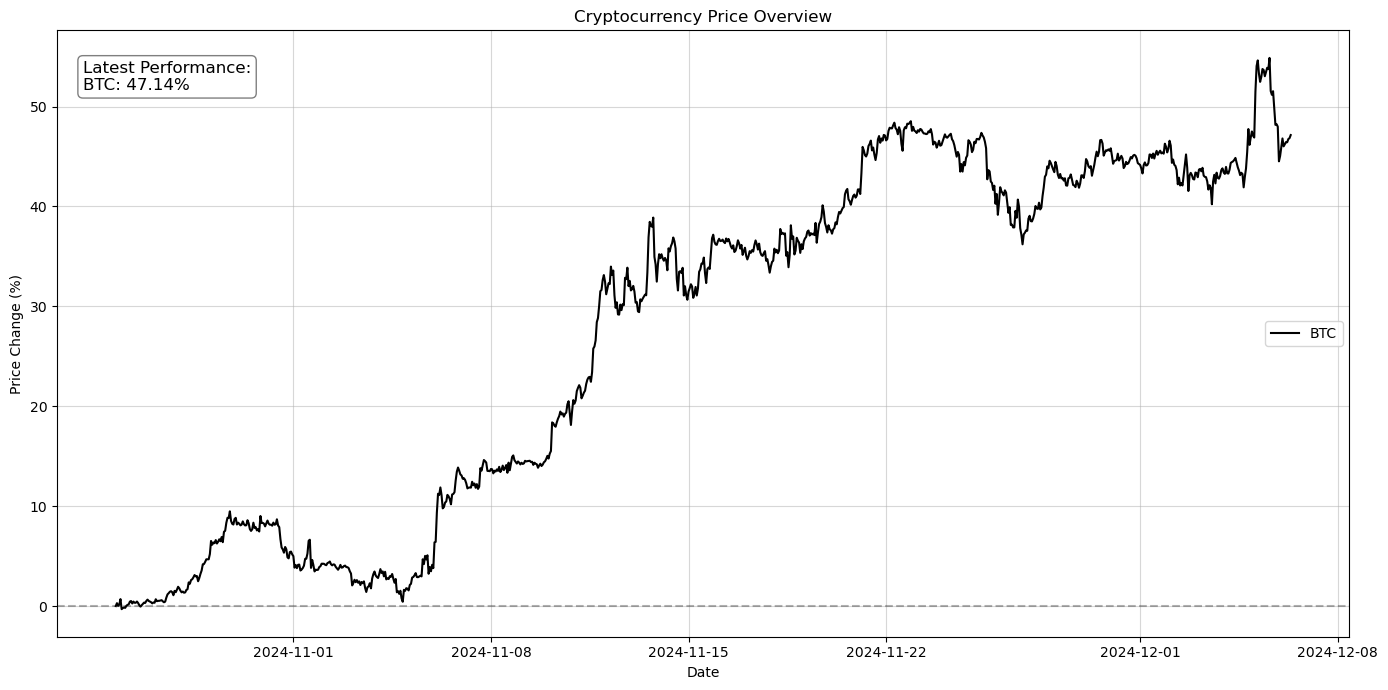

In [ ]:
fetcher = BinanceDataFetcher()
raw_bnb_data = fetcher.get_historical_klines(
    "BTCUSDT",
    interval="1d",
    limit=1000,
    start_date="2024-10-26",
    end_date="2025-10-26"
)

crypto_data_overview(raw_bnb_data)
plot_price_overview(raw_bnb_data)

In [13]:
clean_crypto_data = {}
for symbol, data in raw_bnb_data.items():
    clean_crypto_data[symbol] = clean_data_trading(data, symbol)

data_quality_ok = quick_quality_check(clean_crypto_data)


=== Cleaning Data for BTC ===

No missing values found — data looks clean ✅

Rows dropped (missing OHLCV): 0
Inconsistent High values: 0
Inconsistent Low values: 0
✅ No zero-volume rows detected.

No Outlier Found
No Outlier Found
No Outlier Found
No Outlier Found
Data sorted chronologically from 2024-10-26 to 2025-10-25

Final shape: (365, 5) (removed 0 rows)

BTC:
All checks passed!



In [19]:
volatility_analysis = volatility_analyze_for_grid(clean_crypto_data)


=== Volatility Thresholds and Classifications ===

BTC Classifications:
Hourly Volatility: 0.47% (Medium)
  Threshold - Low: 0.47%, High: 0.47%
Four_hour Volatility: 0.95% (Medium)
  Threshold - Low: 0.95%, High: 0.95%
Daily Volatility: 2.32% (Medium)
  Threshold - Low: 2.32%, High: 2.32%
Weekly Volatility: 6.13% (Medium)
  Threshold - Low: 6.13%, High: 6.13%
Monthly Volatility: 12.70% (Medium)
  Threshold - Low: 12.70%, High: 12.70%
Annual Volatility: 44.28% (Medium)
  Threshold - Low: 44.28%, High: 44.28%

=== Hourly Volatility Rankings ===
BTC: 0.47%

=== 4H Volatility Rankings ===
BTC: 0.95%

=== Daily Volatility Rankings ===
BTC: 2.32%

=== Weekly Volatility Rankings ===
BTC: 6.13%

=== Monthly Volatility Rankings ===
BTC: 12.70%

=== Annual Volatility Rankings ===
BTC: 44.28%

=== Optimal Alpha per Pair per Timeframe ===

BTC:
  hourly     → 0.1
  four_hour  → 0.1
  daily      → 0.1
  weekly     → 0.1
  monthly    → 0.1
  annual     → 0.1

=== Dynamic Grid Multipliers per Pair p

In [20]:
results = run_grid_trading_simulation(
    clean_crypto_data,
    pairs=["BTC"],
    grid_spacing_pct=0.7,
    profit_target_pct=1,
    entry_alloc=0.1,
    num_grids=10,
    budget=70,
)


=== Running Grid Trading Simulation for BTC ===

=== Grid Trading Setup Details ===
Symbol: BTC
Initial Price: $67,092.76
Total Budget: $70.00
Position Size per Grid: $7.00

Grid Levels:
----------------------------------------------------------------------
Level  |      Price      | Discount % |  USD Amount  | Coin Amount 
----------------------------------------------------------------------
  1    | $    66,623.11 |      0.70% | $      7.00 |     0.00011
  2    | $    66,153.46 |      1.40% | $      7.00 |     0.00011
  3    | $    65,683.81 |      2.10% | $      7.00 |     0.00011
  4    | $    65,214.16 |      2.80% | $      7.00 |     0.00011
  5    | $    64,744.51 |      3.50% | $      7.00 |     0.00011
  6    | $    64,274.86 |      4.20% | $      7.00 |     0.00011
  7    | $    63,805.21 |      4.90% | $      7.00 |     0.00011
  8    | $    63,335.57 |      5.60% | $      7.00 |     0.00011
  9    | $    62,865.92 |      6.30% | $      7.00 |     0.00011
  10   | $    62,